In [1]:
import numpy as np
import readdy
import os

/home/chris/miniconda3/envs/tutorials/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
system = readdy.ReactionDiffusionSystem(box_size=[30., 30., 30.])

In [3]:
system.add_species("Substrate", 1.)
system.topologies.add_type("Polymer")
system.add_topology_species("Head", 1.)
system.add_topology_species("Core", 1.)

In [4]:
system.topologies.configure_harmonic_bond("Head", "Core", force_constant=70, length=1.)
system.topologies.configure_harmonic_bond("Core", "Core", force_constant=70, length=1.)
system.topologies.configure_harmonic_angle("Core", "Core", "Core", force_constant=5., equilibrium_angle=np.pi)

system.potentials.add_harmonic_repulsion("Core", "Core", force_constant=70., interaction_distance=1.)

In [5]:
system.topologies.add_spatial_reaction(
    "Bind: Polymer(Head) + (Substrate) -> Polymer(Core--Head)", 
    rate=10.0, radius=1.5
)

In [6]:
simulation = system.simulation(kernel="SingleCPU")

In [7]:
init_top_pos = np.array([
    [ 1. ,0. ,0.],
    [ 0. ,0. ,0.],
    [-1. ,0. ,0.]
])
top = simulation.add_topology("Polymer", ["Head", "Core", "Head"], init_top_pos)
top.get_graph().add_edge(0, 1)
top.get_graph().add_edge(1, 2)

In [8]:
n_particles = 500
positions = np.random.uniform(size=(500,3)) * system.box_size.magnitude - system.box_size.magnitude * 0.5
simulation.add_particles("Substrate", positions)

In [9]:
simulation.output_file = 'growing_polymer.h5'
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)
simulation.observe.topologies(10)
simulation.record_trajectory(10)
simulation.progress_output_stride = 10

In [10]:
simulation.run(200000, .001)

Configured kernel context with:
--------------------------------
 - kBT = 2.43614
 - periodic b.c. = (true, true, true)
 - box size = (30, 30, 30)
 - particle types:
     * Topology particle type "Core" with D=1
     *  particle type "Substrate" with D=1
     * Topology particle type "Head" with D=1
 - potentials of order 2:
     * for types "Core" and "Core"
         * Harmonic repulsion with force constant k=70
 - topology potential configuration:
     - bonds (2):
         - Bonds for particle types Core and Core:
             * Harmonic bond with force constant 70 and length 1
         - Bonds for particle types Head and Core:
             * Harmonic bond with force constant 70 and length 1
     - angles (1):
             * Harmonic angle with force constant 5 and equilibrium angle 3.14159
 - topology types:
     * topology type "Polymer" with 0 structural reactions
 - spatial topology reactions:
     * Topology-particle fusion reaction "Bind: Polymer(Head) + (Substrate) -> Polymer

HBox(children=(HBox(children=(Label(value='Simulation progress'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=20000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [11]:
traj = readdy.Trajectory(simulation.output_file)
time, topology_records = traj.read_observable_topologies()

In [12]:
chain_length = [ len(tops[0].particles) for tops in topology_records ]

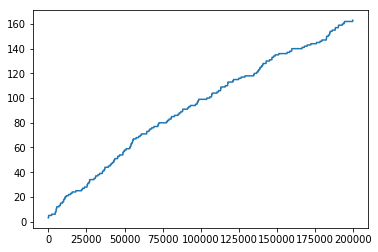

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time, chain_length)
plt.show()